In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import statsmodels.stats.api as sms

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Data Preprocessing

In [2]:
df = pd.read_csv('AB_test_data.csv')

In [3]:
df = df.rename(columns={'purchase_TF': 'conversion', 'Variant': 'variant'})
df.head()

,conversion,variant,date,id
0,False,A,2019-11-08,0x25b44a
1,False,B,2020-08-27,0x46271e
2,False,A,2020-06-11,0x80b8f1
3,False,B,2020-08-22,0x8d736d
4,False,A,2020-08-05,0x96c9c8


In [4]:
df["conversion"].value_counts()

False    110415
True      19585
Name: conversion, dtype: int64

In [5]:
df['variant'].value_counts()

A    125000
B      5000
Name: variant, dtype: int64

In [6]:
con_values = {
    False: 0,
    True: 1
}

df.conversion = df.conversion.map(con_values)
df.head()

,conversion,variant,date,id
0,0,A,2019-11-08,0x25b44a
1,0,B,2020-08-27,0x46271e
2,0,A,2020-06-11,0x80b8f1
3,0,B,2020-08-22,0x8d736d
4,0,A,2020-08-05,0x96c9c8


In [7]:
df.conversion.value_counts()

0    110415
1     19585
Name: conversion, dtype: int64

In [8]:
df[df['date']>'2020-08-01']['variant'].value_counts()

B    4832
A    4814
Name: variant, dtype: int64

## Hypothesis Test

**Definition**

"A" -- control group -- shows current practice; 

"B" -- treatment group -- adds walkability assessment (user review)

* Null hypothesis: R_B = R_A
* Alternative hypothesis: R_B > R_A

In [9]:
from scipy.stats import norm

In [10]:
control_results = df[df['variant'] == 'A']['conversion']
treatment_results = df[df['variant'] == 'B']['conversion']

In [11]:
p_hat = treatment_results.sum()/treatment_results.count()
p = control_results.sum()/control_results.count()
sigma_p_hat = np.sqrt((p*(1-p)/treatment_results.count()))

In [12]:
z = (p_hat-p)/sigma_p_hat
z

5.349273094732516

In [13]:
p_value = norm().sf(z) #sf = 1-CDF
p_value

4.415410062469104e-08

**Reject null hypothesis if z>z_a:**

when a = 5%, z_a = 1.64, we reject the null hypothesis and state that there exists enough evidence to state that adding walkability assessment **will improve the conversion of the customers**. 

## Choosing the optimal sample size

In [14]:
#t_(a/2)
norm().ppf(1-0.05/2)

1.959963984540054

In [15]:
#t_(beta)
norm().ppf(1-0.2)

0.8416212335729143

Following the standards in the literature and using a signifcance level of 0.05, and setting power to 0.80, we have
t_(a/2) = 1.96 and t_beta = 0.84 from standard normal tables.

In [16]:
p_bar = (p_hat+p)/2
p_bar

0.163108

In [17]:
mdf = p_hat-p

In [18]:
sample_size=((norm().ppf(1-0.05/2))*np.sqrt(2*p_bar*(1-p_bar)) + \
             (norm().ppf(1-0.2))*np.sqrt(p*(1-p)+p_hat*(1-p_hat))
            )/(mdf**2)
sample_size

2009.978857988649

In [19]:
sample_c = []
sample_t = []
i = 0
while i < 10:
    control = control_results.sample(n=round(sample_size))
    sample_c.append(control)
    treatment = treatment_results.sample(n=round(sample_size))
    sample_t.append(treatment)
    p_hat = treatment.sum()/treatment.count()
    p = control.sum()/control.count()
    sigma_p_hat = np.sqrt((p*(1-p)/treatment.count()))
    z = (p_hat-p)/sigma_p_hat
    p_value = norm().sf(z)
    print("sample %d: , z score: %f, p_value: %f"%(i,z,p_value))
    if z>1.64:
        print('Reject the null hypothesis.')
    else:
        print('Fail to reject the null hypothesis.')
    i+=1

sample 0: , z score: 2.356930, p_value: 0.009213
Reject the null hypothesis.
sample 1: , z score: 4.658986, p_value: 0.000002
Reject the null hypothesis.
sample 2: , z score: 3.151690, p_value: 0.000812
Reject the null hypothesis.
sample 3: , z score: 7.576998, p_value: 0.000000
Reject the null hypothesis.
sample 4: , z score: 4.316619, p_value: 0.000008
Reject the null hypothesis.
sample 5: , z score: 5.150727, p_value: 0.000000
Reject the null hypothesis.
sample 6: , z score: 4.154232, p_value: 0.000016
Reject the null hypothesis.
sample 7: , z score: 3.639328, p_value: 0.000137
Reject the null hypothesis.
sample 8: , z score: 4.022732, p_value: 0.000029
Reject the null hypothesis.
sample 9: , z score: 2.945094, p_value: 0.001614
Reject the null hypothesis.


## Sequential Test

In [20]:
sample_c[0][0:1]

61999    0
Name: conversion, dtype: int64

In [21]:
sample_c[0]

61999     0
49910     0
71967     0
60220     0
96978     0
         ..
65627     1
101890    0
122854    0
102141    0
116475    1
Name: conversion, Length: 2010, dtype: int64

In [22]:
#boundary
upper = np.log(1/0.05) #alpha = 0.05
lower = np.log(0.2) #beta = 0.2

In [23]:
round(sample_size)

2010

In [33]:
trials=[]
i = 0
walk_list=[]
while i<10:
    ln = 0
    control = sample_c[i]
    treatment = sample_t[i]
    p = control.sum()/control.count()
    p_hat = treatment.sum()/treatment.count()
    j = 0
    walk=[]
    while j < round(sample_size):
        d = treatment[j:j+1]
        if int(d) == 1:
            likelihood = np.log(p_hat/p)
        elif int(d) == 0:
            likelihood = np.log((1-p_hat)/(1-p))
        
        ln += likelihood
        walk.append(ln)
        
        if ln <= lower:
            trials.append(j+1)
            print('sample: %d, index: %d'%(i, j))
            print(ln)
            print('since ln(lambda_n) is lower than the boundary, we accept Ho.')
            break    
        
        elif ln >= upper:
            trials.append(j+1)
            print('sample: %d, index: %d'%(i, j))
            print(ln)
            print('since ln(lambda_n) is higher than the boundary, we reject Ho.')
            break
            
        elif (lower < ln < upper) and (j == round(sample_size)-1):
            trials.append(j+1)
            print('sample: %d'%(i))
            print(ln)
            print('Cannot stop the test prior to using the full sample.')
            
        j+=1
    walk_list.append(walk)   
    i+=1
print('The average iteration is: %.0f'%(sum(trials)/len(trials)))

sample: 0, index: 1810
3.003657641570153
since ln(lambda_n) is higher than the boundary, we reject Ho.
sample: 1, index: 215
3.141203923183758
since ln(lambda_n) is higher than the boundary, we reject Ho.
sample: 2, index: 566
3.026797304948125
since ln(lambda_n) is higher than the boundary, we reject Ho.
sample: 3, index: 107
-1.6728830635253493
since ln(lambda_n) is lower than the boundary, we accept Ho.
sample: 4, index: 1088
3.007406474202855
since ln(lambda_n) is higher than the boundary, we reject Ho.
sample: 5, index: 537
3.1275460804399366
since ln(lambda_n) is higher than the boundary, we reject Ho.
sample: 6, index: 711
3.072846112437053
since ln(lambda_n) is higher than the boundary, we reject Ho.
sample: 7, index: 599
3.08596103673794
since ln(lambda_n) is higher than the boundary, we reject Ho.
sample: 8, index: 612
3.012889724650055
since ln(lambda_n) is higher than the boundary, we reject Ho.
sample: 9, index: 862
3.0092191107552395
since ln(lambda_n) is higher than the 

In [29]:
from matplotlib import pyplot as plt

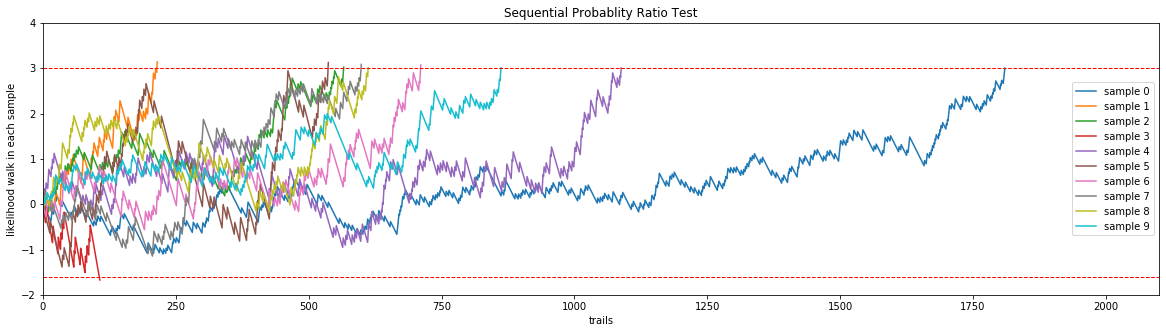

<Figure size 432x288 with 0 Axes>

In [74]:
plt.figure(figsize=(20, 5))

for i in range(len(walk_list)):
    plt.plot(walk_list[i], label='sample %d'%i)

plt.axhline(y=upper, color='r', linestyle='dashed',lw = 1)
plt.axhline(y=lower, color='r', linestyle='dashed',lw = 1)

plt.legend()
plt.xlim([0, 2100])
plt.ylim([-2, 4])
plt.xlabel('trails')
plt.ylabel('likelihood walk in each sample')

plt.title('Sequential Probablity Ratio Test')

plt.show()
plt.savefig('likelihood walk.png')